# Preprocessing: flag faulty images and safe encoder as .keras

flag potentially faulty images using an autoencoder 

In [11]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
metadata = pd.read_csv('../data/rare_species 1/metadata.csv')
metadata.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [13]:
from PIL import Image
import os

# If your file paths are relative, prepend the base directory
BASE_PATH = "../data/rare_species 1/"
metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join(BASE_PATH, x))

# Function to get image size
def get_image_size(path):
    try:
        with Image.open(path) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"[ERROR] Cannot open {path} — {e}")
        return None

# Apply to file paths
metadata['original_size'] = metadata['file_path'].apply(get_image_size)

# Display frequency of different image sizes
print("Unique image sizes:")
print(metadata['original_size'].value_counts())


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Unique image sizes:
original_size
(2048, 1536)    1179
(2048, 1365)     525
(1536, 2048)     457
(640, 480)       154
(1000, 753)      141
                ... 
(2624, 1976)       1
(358, 598)         1
(2071, 2609)       1
(1225, 689)        1
(2164, 1268)       1
Name: count, Length: 5229, dtype: int64


In [14]:
# Adjust this as needed
BASE_PATH = "../data/rare_species 1/"
IMG_SIZE = (128, 128)

# Fix the file paths
metadata = pd.read_csv("../data/rare_species 1/metadata.csv")
metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join(BASE_PATH, x))

# Preprocess function
def preprocess_image(path):
    try:
        with Image.open(path) as img:
            img = img.convert('RGB')  # Ensure 3 channels
            img = img.resize(IMG_SIZE)
            return img_to_array(img) / 255.0
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

# Load images
metadata['image_array'] = metadata['file_path'].apply(preprocess_image)
metadata = metadata.dropna(subset=['image_array'])

# Stack valid images
X = np.stack(metadata['image_array'].values)
print(f"Loaded {len(X)} images with shape {X.shape[1:]}")


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Loaded 11983 images with shape (128, 128, 3)


In [15]:
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

autoencoder = build_autoencoder(input_shape=X.shape[1:])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,347 (52.14 KB)

 Trainable params: 13,347 (52.14 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

# history = autoencoder.fit(
#     X_train, X_train,
#     epochs=20,
#     batch_size=32,
#     validation_data=(X_val, X_val),
#     verbose=1
# )


In [17]:
# Load the saved autoencoder model
loaded_autoencoder = tf.keras.models.load_model("../models/autoencoder_species.keras")

# Get reconstruction errors using the loaded model
reconstructed = loaded_autoencoder.predict(X)
reconstruction_errors = np.mean((X - reconstructed) ** 2, axis=(1, 2, 3))

# Determine threshold (reuse the previous threshold or calculate a new one)
threshold = np.percentile(reconstruction_errors, 95)

# Save errors to metadata
metadata['reconstruction_error'] = reconstruction_errors
metadata['is_faulty'] = metadata['reconstruction_error'] > threshold

print(f"Flagged {metadata['is_faulty'].sum()} images as potentially faulty.")

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step
Flagged 600 images as potentially faulty.


In [18]:
# Get reconstruction errors
reconstructed = autoencoder.predict(X)
reconstruction_errors = np.mean((X - reconstructed) ** 2, axis=(1, 2, 3))

# Determine threshold (95th percentile or any other strategy)
threshold = np.percentile(reconstruction_errors, 95)

# Save errors to metadata
metadata['reconstruction_error'] = reconstruction_errors
metadata['is_faulty'] = metadata['reconstruction_error'] > threshold

print(f"Flagged {metadata['is_faulty'].sum()} images as potentially faulty.")


375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
Flagged 600 images as potentially faulty.


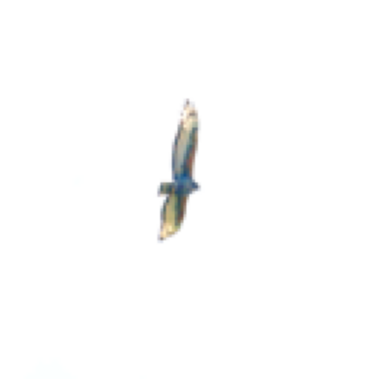

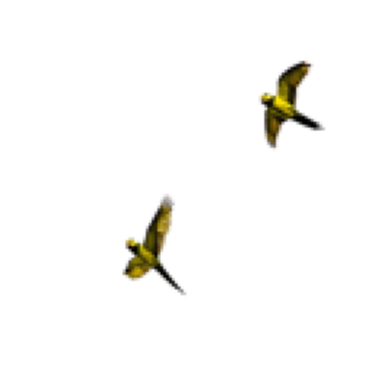

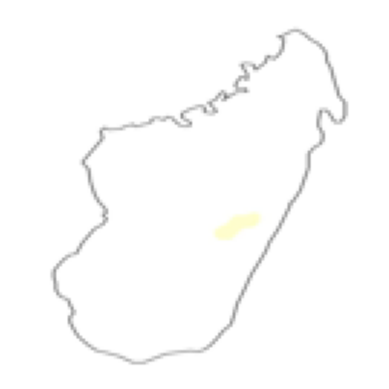

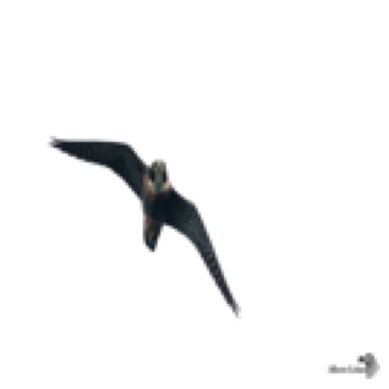

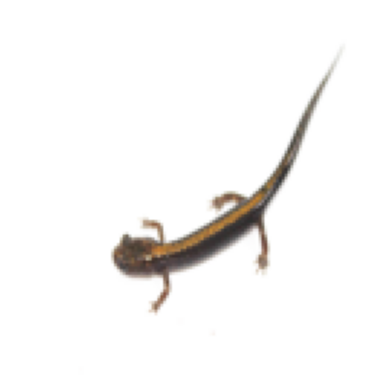

In [19]:
def show_image(arr):
    plt.imshow(arr)
    plt.axis('off')
    plt.show()

# Show a few faulty images
faulty = metadata[metadata['is_faulty']].sort_values("reconstruction_error", ascending=False)
for i in range(5):
    show_image(faulty.iloc[i]['image_array'])


In [20]:
# Save the complete model to a .keras file (preferred format in TF 2.13+)
#autoencoder.save("../models/autoencoder_species.keras")